# Notebook de treino de modelo

Este notebook foi desenvolvido ao longo das sprints 2, 3 e 4 com o objetivo de fazer o tratamento dos dados para a criação de fetaures para o modelo e a criação do modelo em si. Os comentários presentes no notebook buscam explicar os blocos de código e a lógica do processamento feito para facilitar o entendimento da pipeline de treino dos dados do modelo criado e auxiliar na experimentação na busca pela melhoria nas previsões.

In [2]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import normalize
from datetime import datetime, timedelta

## Processamento dos dados

Os próximos blocos de código buscam receber e transformar os dados fornecidos pelo parceiro em features que utilizaremos no modelo.

### Tabela STATUS

Começaremos com a tabela "STATUS" que possui os dados de status utilizados na fábrica e o horário que este status foi lançado dos KNRs, na célula a seguir, estamos abrindo o arquivo Excel e fazendo uma transformação inicial para ajustar o nome das colunas que aparece como a primeira linha do banco de dados e retirando a coluna de índice.

In [3]:
df_st = pd.read_excel("STATUS_PREDICTOR_ANO.xlsx")
df_st.columns = df_st.loc[0]
df_st = df_st.drop(index=0)
df_st = df_st.drop(columns=df_st.columns[0])

FileNotFoundError: [Errno 2] No such file or directory: 'STATUS_PREDICTOR_ANO.xlsx'

Como queremos saber quando determinado KNR entrou nos checkpoints estudados (ZP5, ZP5A, ZP6 e ZP7, estamos separando o ZP6 em ZP6 e Cabinagem pois isto aumenta a acurácia do modelo), começamos classificando os códigos de status aos seus checkpoints correspondentes e criando a coluna "ZP" para armazenar este dado, depois filtramos o banco de dados para que ele possua apenas status os quais sabemos o checkpoint.

In [5]:
df_st = df_st.copy()
df_st["ZP"] = ["" for a in range(df_st.shape[0])]
zp5 = ['R640','R650','R700','R754','R755','R500','R645','R655','R701',"R750"]
zp5a = ['L534','L535','L536','L537','L538','L539','L541','L542','L543','L544','L545','L546','L547','L548', 'L535', "L540"]
zp6 = ["G700", "M600", 'M599','M591','M592','M593','M594','M595','M596','M643','M644','M647','M648','M651','M652','M655','M656','M673','M674','M677','M678','M681','M682']
cab = ['M619','M643','M644','M655','M656','M673','M674', 'M619', "M620"]
zp7 = ["M700", 'M695','M698','M701','M702','M704','M711','M712','M721','M722', 'M699']
for k in df_st.index:
    val = df_st.loc[k,"STATUS"]
    if val in zp5:
        df_st.loc[k,"ZP"] = "ZP5"
    elif val in zp5a:
        df_st.loc[k,"ZP"] = "ZP5A"
    elif val in zp6:
        df_st.loc[k,"ZP"] = "ZP6"
    elif val in cab:
        df_st.loc[k,"ZP"] = "CABINES"
    elif val in zp7:
        df_st.loc[k,"ZP"] = "ZP7"
    else:
        df_st.loc[k,"ZP"] = "-"
    
        
df_st = df_st[df_st["ZP"]!="-"]

Após isto, agrupamos os dados de checkpoint e data de lançamento do dado por KNR para organizar os dados de modo que cada KNR seja único.

In [6]:
df_st["ZP"] = df_st.groupby(["KNR"])["ZP"].transform(lambda x: "; ".join(x))
df_st["DATA"] = df_st["DATA"].astype(str)
df_st["DATA"] = df_st.groupby(["KNR"])["DATA"].transform(lambda x: "; ".join(x))
df_st = df_st.drop_duplicates(subset=["KNR","ZP"])

Neste bloco, criamos a coluna temporária "all" para armazenar caso o KNR possua pelo menos um status lançado de cada checkpoint estudado (1 para sim e 0 para não), filtramos para que apenas os KNRs que possuem estes dados e removemos as colunas "all" e "STATUS".

In [7]:
df_st["all"] = [0 for k in range(df_st.shape[0])]
zps = set(["ZP5","ZP5A","ZP6","CABINES","ZP7"])
for r in df_st.index:
    arr = set(df_st.loc[r,"ZP"].split("; "))
    df_st.loc[r,"all"] = 1 if arr == zps else 0
df_st["all"].value_counts()
df_st = df_st[df_st["all"]==1]
df_st = df_st.drop(columns=["STATUS","all"])

Agora criamos colunas para armazenar a data o qual o KNR passou por cada checkpoint estudado.

In [9]:
df_st = df_st.reset_index()
df_st = df_st.drop(columns=["index"])
df_st["ZP5_t"] = ["" for a in range(df_st.shape[0])]
df_st["ZP5A_t"] = ["" for a in range(df_st.shape[0])]
df_st["ZP6_t"] = ["" for a in range(df_st.shape[0])]
df_st["CABINES_t"] = ["" for a in range(df_st.shape[0])]
df_st["ZP7_t"] = ["" for a in range(df_st.shape[0])]

Com as colunas criadas, utilizamos os dados de DATA e ZP para determinar o horário do primeiro status de cada checkpoint e adicionamos o dado na coluna correspondente.

In [10]:
for a in range(df_st.shape[0]):
    arr_t = df_st.loc[a,"DATA"].split("; ")
    arr_z = df_st.loc[a,"ZP"].split("; ")
    has_seen= []
    for b in range(len(arr_t)):
        if arr_z[b] not in has_seen:
            df_st.loc[a,str(arr_z[b]+"_t")] = arr_t[b]
            has_seen.append(arr_z[b])

Com isto, removemos as colunas que utilizamos ("DATA" e "ZP") e criamos colunas para armazenar o tempo gasto nos checkpoints estudados.

In [11]:
df_st = df_st.drop(columns=["DATA","ZP"])
df_st["delta_ZP5"] = [0.0 for a in range(len(df_st))]
df_st["delta_ZP5A"] = [0.0 for a in range(len(df_st))]
df_st["delta_ZP6"] = [0.0 for a in range(len(df_st))]
df_st["delta_CABINES"] = [0.0 for a in range(len(df_st))]

Após a adição das colunas necessárias, subtraímos a data de entrada no checkpoint com a data de entrada no próximo checkpoint, convertemos para minutos e escrevemos os valores nas colunas correspondentes, removendo as colunas de data de entrada depois do processo.

In [12]:
for a in range(len(df_st)):
    for b in range(1,5):
        t0 = datetime.strptime(df_st.iloc[a,b], "%Y-%m-%d %H:%M:%S")
        t1 = datetime.strptime(df_st.iloc[a,b+1], "%Y-%m-%d %H:%M:%S")
        delta = t1 - t0
        df_st.iloc[a,b+5] = round(delta.seconds/60,2)
df_st = df_st.drop(columns=["ZP5_t","ZP5A_t","ZP6_t","CABINES_t","ZP7_t"])

Por fim, estandartizamos os dados de tempo e exportamos o banco de dados em csv caso queiramos utilizá-lo em outra aplicação.

In [13]:
colunas = df_st.columns
for i in range(1,5):
    df_st[colunas[i]] = (df_st[colunas[i]] - df_st[colunas[i]].mean()) / df_st[colunas[i]].std() 
df_st.to_csv("STATUS_to_ZPtime.csv", index=False)

### Tabela RESULTS

Como as tabelas do tipo RESULTS são muito grandes, o processamento foi feito no arquivo "BATCHES.py" que quebra o processamento em vários datasets menores, assim, o dado que retiramos é o número de vezes que a operação teve que ser feita por torque de cada KNR. Após este processamento, estamos importando os datasets e concatenando seus dados para criar um banco de dados completo.

In [2]:
df_re = pd.read_csv("DATASETS/Results_0.csv")
for i in range(1,694):
    df_temp = pd.read_csv(f"DATASETS/Results_{i}.csv")
    df_re = pd.concat([df_re,df_temp])
df_re = df_re.reset_index()
df_re = df_re.drop(columns=["index"])

Após isto, estamos mudando o tipo de todas as tabelas exceto "KNR" para inteiros e juntando dados de KNRs que foram separados no processo de divisão da tabela RESULTS, garantindo que cada KNR aparece apenas uma vez.

In [3]:
cols = df_re.columns
for c in range(1,len(cols)):
    df_re[cols[c]] = df_re[cols[c]].fillna(0)
    df_re[cols[c]] = df_re[cols[c]].astype(int)
    df_re[cols[c]] = df_re.groupby(["KNR"])[cols[c]].transform("sum")
    df_re = df_re.drop_duplicates(subset=["KNR"])

### Tabela de features

Com o tratamento das tabelas STATUS e RESULTS, começamos a juntar as features para criar o modelo final.

In [14]:
df = df_re.merge(df_st, on="KNR")

Depois disso, adicionamos a nossa coluna de target ("HAS_FALHA") e preenchemos ela com a informação de se o KNR aparece na tabela de FALHAS.

In [15]:
df["HAS_FALHA"] = [0 for a in range(len(df))]
df_fa = pd.read_csv("FALHAS_KNR.csv")
knrs = list(df_fa["KNR"])
for i in range(len(df)):
    df.loc[i,"HAS_FALHA"] = 1 if df.loc[i,"KNR"] in knrs else 0

Após, retiramos as colunas com apenas um valor.

In [16]:
cols = df.columns
to_drop = []
for c in range(1,len(cols)):
    if len(df[cols[c]].unique()) == 1:
        to_drop.append(cols[c])
df = df.drop(columns=to_drop)

Por fim, analisamos o número de KNRs com falhas e os sem falhas e selecionamos parte do banco de dados de maneira que ambos tenham o mesmo número de dados.

In [18]:
counts = df["HAS_FALHA"].value_counts()
if counts[0] < counts[1]:
    F = df[df["HAS_FALHA"] == 1].sample(n=counts[0])
    nF = df[df["HAS_FALHA"] == 0]
elif counts[0] > counts[1]:
    nF = df[df["HAS_FALHA"] == 0].sample(n=counts[1])
    F = df[df["HAS_FALHA"] == 1]


df = pd.concat([F,nF])
df = df.reset_index()
df = df.drop(columns=["index"])
df["HAS_FALHA"].value_counts()

HAS_FALHA
1    7890
0    7890
Name: count, dtype: int64

## Criação do modelo

As células seguintes possuem o código para criação e treino do modelo e elas serão divididas em duas ferramentas que apresentam dois modelos diferentes, o pycaret e o keras. Começaremos com os modelos criados pelo pycaret pois ele testa diversos modelo com diferentes hiperparâmetros para achar a melhor combinação, desta maneira, importamos a biblioteca necessária, removemos a coluna "KNR", dividimos os dados em treino e teste e fazemos o setup para o pycaret 

In [19]:
from pycaret.classification import *
from sklearn.model_selection import train_test_split


df = df.drop(columns=["KNR"])

y = df["HAS_FALHA"]
X = df.drop(columns=["HAS_FALHA"])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
df_train = X_train.copy()
df_train["HAS_FALHA"] = y_train

s = setup(df_train, target = 'HAS_FALHA', session_id = 123, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,HAS_FALHA
2,Target type,Binary
3,Original data shape,"(15780, 264)"
4,Transformed data shape,"(15780, 264)"
5,Transformed train set shape,"(11046, 264)"
6,Transformed test set shape,"(4734, 264)"
7,Numeric features,263
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


Depois do setup, chamamos o comparador de modelos, retirando alguns modelos que causam problema no treinamento.

In [20]:
best = compare_models(errors="raise", exclude=['lightgbm',"xgboost","catboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8947,0.9606,0.9493,0.8559,0.9001,0.7894,0.7943,0.1720
gbc,Gradient Boosting Classifier,0.8937,0.9579,0.9819,0.8348,0.9023,0.7874,0.8001,2.0730
et,Extra Trees Classifier,0.8823,0.9531,0.9178,0.8571,0.8863,0.7646,0.7667,0.1670
lr,Logistic Regression,0.8782,0.9489,0.9361,0.8391,0.8849,0.7565,0.7617,0.1510
ada,Ada Boost Classifier,0.8765,0.9493,0.9370,0.8360,0.8836,0.7530,0.7587,0.4680
ridge,Ridge Classifier,0.8741,0.9423,0.9540,0.8226,0.8834,0.7481,0.7579,0.0850
lda,Linear Discriminant Analysis,0.8731,0.9416,0.9526,0.8220,0.8824,0.7461,0.7558,0.1280
dt,Decision Tree Classifier,0.8634,0.8634,0.8644,0.8627,0.8635,0.7268,0.7269,0.1180
knn,K Neighbors Classifier,0.8527,0.9270,0.8707,0.8405,0.8553,0.7054,0.7060,0.1280
svm,SVM - Linear Kernel,0.8446,0.9438,0.8468,0.8571,0.8399,0.6893,0.7075,0.2380


Obtendo a informação do melhor modelo encontrado, utilizamos os dados de teste a confirmamos as métricas do modelo.

Precisão (treino): 0.9682179341657208  |  Precisão (teste): 0.9682179341657208
Recall (treino): 0.9682179341657208  |  Recall (teste): 0.9654377880184332
F1-score (treino): 0.9682179341657208  |  F1-score (teste): 0.9654377880184332


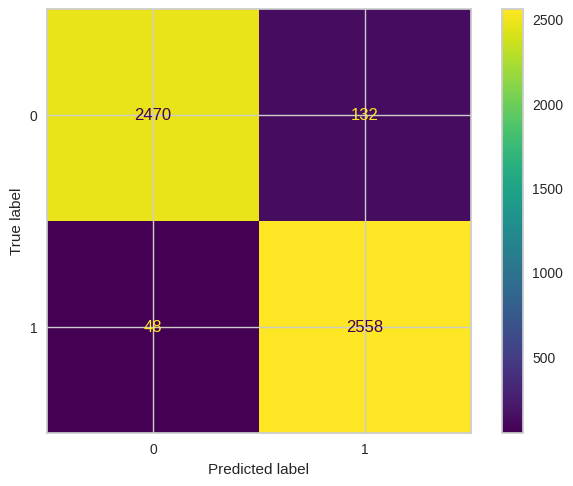

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, f1_score

y_predTe = best.predict(X_test)
y_predTr = best.predict(X_train)
print(f"Precisão (treino): {best.score(X_train,y_train)}  |  Precisão (teste): {best.score(X_test,y_test)}")
print(f"Recall (treino): {recall_score(y_train, y_predTr,average='micro')}  |  Recall (teste): {recall_score(y_test, y_predTe,average='micro')}")
print(f"F1-score (treino): {f1_score(y_train, y_predTr,average='micro')}  |  F1-score (teste): {f1_score(y_test, y_predTe,average='micro')}")
_ = ConfusionMatrixDisplay.from_estimator(best,X_test,y_test)

Depois do pycaret, utilizamos uma rede neural com neurônios do tipo Dense para fazer a previsão como uma segunda opção de modelo. Para tal, separamos novamente entre dados de treino e teste.

In [ ]:
import joblib
joblib.dump(best, "model.pkl")

In [36]:
from sklearn.model_selection import train_test_split

y =df["HAS_FALHA"]
X = df.drop(columns=["HAS_FALHA"])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=1234)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [37]:
model = Sequential()
model.add(Input((263,)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

In [38]:
model.build()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,866 (1.33 MB)

 Trainable params: 348,866 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
adam = Adam()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [40]:
historico = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5760 - loss: 0.6564 - val_accuracy: 0.8530 - val_loss: 0.3355
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8451 - loss: 0.3612 - val_accuracy: 0.8704 - val_loss: 0.2943
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8677 - loss: 0.3060 - val_accuracy: 0.8752 - val_loss: 0.2842
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8747 - loss: 0.2918 - val_accuracy: 0.8728 - val_loss: 0.2903
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8629 - loss: 0.3051 - val_accuracy: 0.8761 - val_loss: 0.2937
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8607 - loss: 0.3181 - val_accuracy: 0.8794 - val_loss: 0.2840
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8718 - loss: 0.2946 - val_accuracy: 0.8813 - val_loss: 0.2756
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8707 - loss: 0.2838 - val_accu

Text(0, 0.5, 'acuracia')

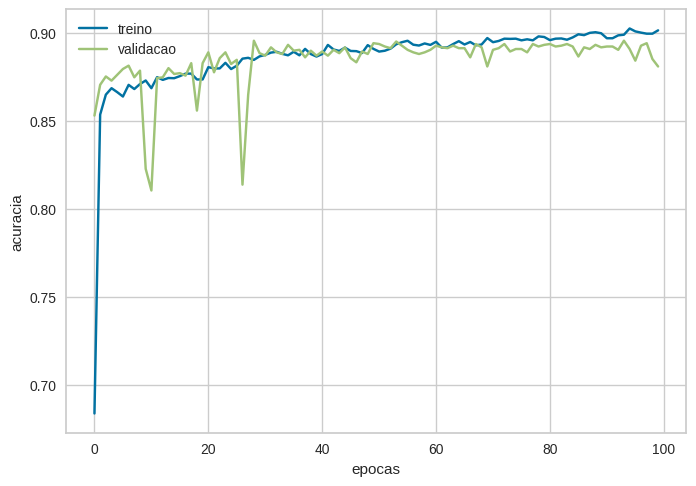

In [41]:
import matplotlib.pyplot as plt

plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.legend(['treino', 'validacao'])
plt.xlabel('epocas')
plt.ylabel('acuracia')

In [42]:
eva = model.predict(X_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


In [43]:
eva

array([[0.12937781, 0.86724603],
       [0.9730548 , 0.01689883],
       [0.987724  , 0.00652555],
       ...,
       [0.07788361, 0.91027164],
       [0.4596889 , 0.5495224 ],
       [0.03860505, 0.93125045]], dtype=float32)

In [44]:
for a in range(len(eva)):
    m = 0
    for b in range(len(eva[a])):
        m = max(m,eva[a][b])
    for b in range(len(eva[a])):
        eva[a][b] = 0 if eva[a][b] != m else 1

In [45]:
eva = np.array(eva, dtype=bool)
y_test = np.array(y_test, dtype=bool)

In [46]:
eva2 = []
for a in eva:
    for b in range(len(a)):
        if a[b]:
            eva2.append(b)
            break

In [47]:
y2_te = []
for a in y_test:
    for b in range(len(a)):
        if a[b]:
            y2_te.append(b)
            break

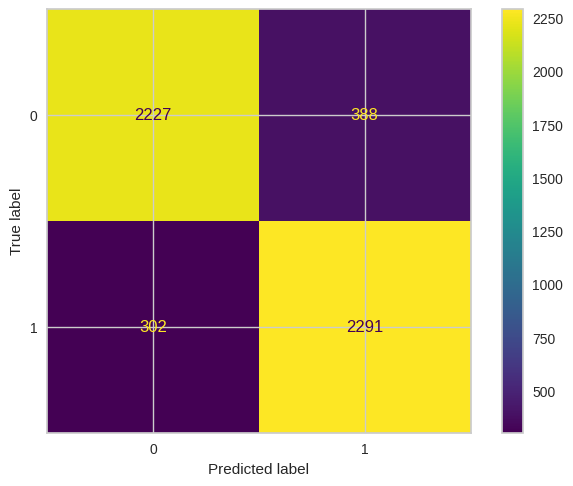

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y2_te, eva2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

In [49]:
recall_score(y2_te, eva2,average='micro')

0.8675115207373272

In [ ]:
model.save("Previsao_tem_falha.keras")